# Query-Classifier 

This notebook makes a BERT-based classifier that differenciates between Gmail and Calendar queries. For calendar queries, it can also extract a time range from the user's input.

---

## Features

- **Classifies queries** as either `gmail` or `calendar`.
- **Extracts time ranges** from calendar queries using natural language expressions.
- **Interactive widget** for testing queries live.
- **Evaluation metrics** and confusion matrix for model performance.

## Imports

- PyTorch and HuggingFace Transformers for model and training
- Pandas for data manipulation
- Scikit-learn for splitting and metrics
- tqdm for progress bars
- seaborn and matplotlib for plotting

In [1]:
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Load and Shuffle Data

Loads the labeled queries from `labeled-queries.csv` and shuffles the data randomly.

In [2]:
df = pd.read_csv("labeled-queries.csv")
df = df.sample(frac=1,random_state=56).reset_index(drop=True)

## Label Mapping

Maps numeric IDs to labels -> "gmail": 0, "calendar": 1

In [3]:
label_id = {"gmail": 0, "calendar": 1}
df["label_id"] = df["label"].map(label_id)

df.head()

,query,label,label_id
0,When did we last discuss the roadmap?,calendar,1
1,Do I have any schedule conflicts?,calendar,1
2,Search emails with word 'urgent' in subject,gmail,0
3,Did I get a response to my follow-up?,gmail,0
4,Check any invites from operations,calendar,1


## Train/Validation/Test Split

- Splits the dataset into **training**, **validation**, and **test** sets.
- Stratified sampling is used to keep label balance for all three sets.

In [4]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 159, Val: 34, Test: 35


## Tokenizer Setup and Model Specifications

This loads the [DistilBERT](https://huggingface.co/distilbert-base-uncased) tokenizer and prepares the training queries to input in model.

**Model:**  
- **Type:** DistilBERT (Distilled BERT: 40% smaller and 60% faster while retaining 97% of BERT's performance)
- **Pretrained weights:** `distilbert-base-uncased` (lowercase English, 6 transformer layers)
- **Task:** Sequence classification (Gmail vs Calendar)

**Tokenizer:**  
- **Type:** `DistilBertTokenizerFast` from HuggingFace Transformers
- **Pretrained vocabulary:** English, uncased (all input lowercased)
- **Purpose:** Converts text queries into token and attention masks for the model

**Tokenization Parameters:**  
- `truncation=True`: Truncate queries longer than `max_length`
- `padding=True`: Pad queries shorter than `max_length`
- `max_length=32`: All queries are padded/truncated to 32 tokens
- `return_tensors="pt"`: Output is returned as PyTorch tensors for model input

**Summary:**  
This step makes sure that all queries are consistently preprocessed and ready to input in the DistilBERT model for fine-tuning it to Gmail/Calander classification.

In [5]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(
    train_df["query"].tolist(),
    truncation=True,
    padding=True,
    max_length=32,
    return_tensors="pt"
)
print(tokenizer.decode(encodings["input_ids"][0]))

[CLS] show recent interactions with sarah [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## Dataset and DataLoader Setup

This defines a custom PyTorch `Dataset` class named (`QueryDataset`) that handles query data and labels. It sets up DataLoaders for proper batching during training, validation, and testing.

**QueryDataset Class:**
- **Inputs:** DataFrame (`df`), tokenizer, and `max_length` for tokenization.
- **Functionality:**  
  - Transforms queries and labels from DataFrame to lists.
  - Uses the tokenizer to encode queries into IDs and attention masks, padding/truncating to `max_length`.
  - Implements `__len__` and `__getitem__` methods to find dataset size and return a single sample for a given index.

**DataLoader Setup:**
- **train_loader:** Loads batches of training data. Shuffles each epoch for generalization.
- **val_loader:** Loads batches of validation data.
- **test_loader:** Loads batches of test data.
- **Batch size:** 8

**Summary:**  
This step prepares data into objects for easy & efficient access to tokenized queries and their lables for training.

In [6]:
from torch.utils.data import Dataset, DataLoader

class QueryDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=32):
        self.queries = df["query"].tolist()
        self.labels = df["label_id"].tolist()
        self.encodings = tokenizer(
            self.queries,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = QueryDataset(train_df, tokenizer)
val_dataset = QueryDataset(val_df, tokenizer)
test_dataset = QueryDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

## Model and Optimizer Setup

This loads the DistilBERT model for sequence classification and prepares it for training.

**Model:**
- **Type:** `DistilBertForSequenceClassification` from HuggingFace Transformers.
- **Pretrained weights:** `"distilbert-base-uncased"` (English, all lowercase).
- **Number of labels:** `2` (for binary classification: Gmail vs Calendar).
- **Purpose:** Finetunes DistilBERT to classify queries as either Gmail or Calendar.

**Device Selection:**
- Automatically uses a GPU (`cuda`) if available, otherwise falls back to CPU.

**Optimizer:**
- **Type:** `AdamW` (Adam optimizer with weight decay, recommended for Transformers).
- **Learning rate:** `2e-5` (a standard starting value for fine-tuning BERT-like models).

**Summary:**  
Initializing the model and optimizer. Alocates training to GPU.

In [7]:
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on device: {device}")

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on device: cuda


## Training and Validation Loop

This trains the DistilBERT classifier over multiple epochs and evaluates its performance on the validation set after each epoch.

**Training:**
- Runs for `num_epochs`.
- For each epoch:
  - Sets the model to training mode.
  - Iterates over batches from `train_loader`.
  - Moves each batch to the best device (CPU/GPU).
  - Computes the loss, performs backpropagation, and updates model weights using the optimizer.
  - Tracks and prints the average training loss for the epoch.

**Validation:**
- After each epoch, switches the model to evaluation mode.
- Iterates over batches from `val_loader`.
- Computes validation loss and accuracy by comparing predictions to true labels.
- Prints the average validation loss and accuracy for the epoch.

**Summary:**  
This loop finetunes the model on labeled data and provides feedback on how well the model is learning and generalizing.

In [8]:
from tqdm.auto import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training on device: {device}")
    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Training loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_acc:.4f}")


Epoch 1/5 - Training on device: cuda


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.6466
Validation loss: 0.4845, Validation accuracy: 0.7941

Epoch 2/5 - Training on device: cuda


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 - Training loss: 0.3519
Validation loss: 0.2927, Validation accuracy: 0.8529

Epoch 3/5 - Training on device: cuda


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 - Training loss: 0.1451
Validation loss: 0.2304, Validation accuracy: 0.8529

Epoch 4/5 - Training on device: cuda


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.0458
Validation loss: 0.2839, Validation accuracy: 0.8824

Epoch 5/5 - Training on device: cuda


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.0190
Validation loss: 0.2853, Validation accuracy: 0.9118


## Evaluation and Confusion Matrix

Creates a evaluation function and visualizes the model's performance on the test set.

**Evaluation Function:**
- `evaluate(model, loader)`:  
  - Sets the model to evaluation mode.
  - Iterates over the provided DataLoader.
  - Collects predictions and true labels for all batches.
  - Computes accuracy, precision, recall, F1 score, and the confusion matrix.

**Test Set Evaluation:**
- Calls `evaluate` on the test set and prints the main metrics:
  - **Accuracy:** Overall correctness of predictions.
  - **Precision:** How many predicted positives are true positives.
  - **Recall:** How many actual positives are correctly predicted.
  - **F1 Score:** Harmonic mean of precision and recall.

**Confusion Matrix:**
- Plots a heatmap of the confusion matrix using seaborn.
- X-axis: Predicted labels (`gmail`, `calendar`)
- Y-axis: True labels (`gmail`, `calendar`)

**Summary:**  
This step provides a quantitative and visual summary of the model's classification performance.

Test - Accuracy: 0.94, Precision: 0.94, Recall: 0.94, F1: 0.94


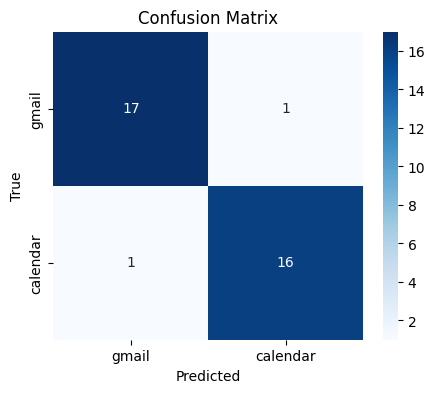

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    cm = confusion_matrix(labels, preds)
    return acc, precision, recall, f1, cm

test_acc, test_prec, test_rec, test_f1, cm = evaluate(model, test_loader)
print(f"Test - Accuracy: {test_acc:.2f}, Precision: {test_prec:.2f}, Recall: {test_rec:.2f}, F1: {test_f1:.2f}")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gmail", "calendar"], yticklabels=["gmail", "calendar"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Time Range Extraction Utility

Creates `extract_time_range` function, which extracts a date or date range from the queries using regular expressions & the `dateparser` library.

**Functionality:**
- **Handles common time expressions:**  
  - `"last month"`, `"this month"`, `"next month"`
  - `"last week"`, `"this week"`, `"next week"`
  - `"yesterday"`, `"today"`
  - Explicit `"Month Year"` (e.g., "June 2025")
- **Fallback:**  
  - If no pattern matches, tries to parse any date in the query using `dateparser`.
- **Returns:**  
  - A dictionary with `"from"` and `"to"` keys (ISO date strings) if a time range is found.
  - `None` if no recognizable date or range is found.

**Negative**
- It is a purely functional method hence doesnt produce intelegent answers just factual ranges from the given set of time expression.
- to get intelegent answers over a wide range of Natural language queries we have to use more complex transfrom models like GPT

**Summary:**  
This utility enables the model to extract structured time ranges from user queries.

In [10]:
import dateparser
import calendar
import re
from datetime import datetime, timedelta

def extract_time_range(query):
    query_lower = query.lower()

    if "last month" in query_lower:
        today = datetime.today()
        year = today.year if today.month > 1 else today.year - 1
        month = today.month - 1 if today.month > 1 else 12
        from_date = f"{year}-{month:02d}-01"
        last_day = calendar.monthrange(year, month)[1]
        to_date = f"{year}-{month:02d}-{last_day:02d}"
        return {"from": from_date, "to": to_date}

    if "this month" in query_lower:
        today = datetime.today()
        year = today.year
        month = today.month
        from_date = f"{year}-{month:02d}-01"
        last_day = calendar.monthrange(year, month)[1]
        to_date = f"{year}-{month:02d}-{last_day:02d}"
        return {"from": from_date, "to": to_date}

    if "last week" in query_lower:
        today = datetime.today()
        start = today - timedelta(days=today.weekday() + 7)
        end = start + timedelta(days=6)
        return {"from": start.strftime("%Y-%m-%d"), "to": end.strftime("%Y-%m-%d")}

    if "this week" in query_lower:
        today = datetime.today()
        start = today - timedelta(days=today.weekday())
        end = start + timedelta(days=6)
        return {"from": start.strftime("%Y-%m-%d"), "to": end.strftime("%Y-%m-%d")}

    if "yesterday" in query_lower:
        yesterday = datetime.today() - timedelta(days=1)
        date_str = yesterday.strftime("%Y-%m-%d")
        return {"from": date_str, "to": date_str}

    if "today" in query_lower:
        today = datetime.today().strftime("%Y-%m-%d")
        return {"from": today, "to": today}

    if "next week" in query_lower:
        today = datetime.today()
        start = today + timedelta(days=(7 - today.weekday()))
        end = start + timedelta(days=6)
        return {"from": start.strftime("%Y-%m-%d"), "to": end.strftime("%Y-%m-%d")}

    if "next month" in query_lower:
        today = datetime.today()
        year = today.year + 1 if today.month == 12 else today.year
        month = 1 if today.month == 12 else today.month + 1
        from_date = f"{year}-{month:02d}-01"
        last_day = calendar.monthrange(year, month)[1]
        to_date = f"{year}-{month:02d}-{last_day:02d}"
        return {"from": from_date, "to": to_date}

    match = re.search(r'([A-Za-z]+)\s+(\d{4})', query)
    if match:
        month_str, year_str = match.groups()
        try:
            month = list(calendar.month_name).index(month_str.capitalize())
            year = int(year_str)
            from_date = f"{year}-{month:02d}-01"
            last_day = calendar.monthrange(year, month)[1]
            to_date = f"{year}-{month:02d}-{last_day:02d}"
            return {"from": from_date, "to": to_date}
        except ValueError:
            pass

    date = dateparser.parse(query)
    if date:
        date_str = date.strftime("%Y-%m-%d")
        return {"from": date_str, "to": date_str}
    return None

## Interactive Query Classification Widget

This cell creates an interactive widget for testing the trained classifier on custom queries.

**Components:**
- **Text box (`query_box`):**  
  - Allows the user to type a query for classification.
- **Output area (`output`):**  
  - Displays the predicted label 
  - If applicable, the extracted time range.

**Program Flow:**
- When the user submits a query:
  - The input is tokenized and sent to the trained model.
  - The model predicts whether the query is related to Gmail or Calendar.
  - The prediction is displayed.
  - If the query is classified as "calendar", the `extract_time_range` function is called to extract any time range from the query, and the result is displayed.

**Why this is useful:**
- Provides a quick, interactive way to test the model's predictions and time extraction logic on arbitrary user input.
- Useful for demos, debugging, and validating model behavior in real time.

**Summary:**  
This widget enables hands-on testing of the classifier and time extraction utility directly in the notebook.

In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output

id_label = {0: "gmail", 1: "calendar"}

query_box = widgets.Text(
    value='',
    placeholder='Type your query here',
    description='Query:',
    disabled=False
)

output = widgets.Output()

def on_submit(change):
    with output:
        clear_output()
        user_query = query_box.value
        inputs = tokenizer([user_query], padding=True, truncation=True, max_length=32, return_tensors="pt").to(device)
        model.eval()
        with torch.no_grad():
            logits = model(**inputs).logits
            pred = torch.argmax(logits, dim=1).cpu().item()
        pred_label = id_label[pred]
        print(f"Query: {user_query}\nPredicted: {id_label[pred]}")
        if pred_label == "calendar":
            time_range = extract_time_range(user_query)
            if time_range:
                print(f"Extracted time range: {time_range}")

query_box.on_submit(on_submit)

display(query_box, output)

/tmp/ipykernel_87568/4063338657.py:31: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  query_box.on_submit(on_submit)


Text(value='', description='Query:', placeholder='Type your query here')

Output()

## Automated Test Case Evaluation

This cell runs the trained classifier on a set of test queries, printing detailed results for each case and a summary at the end.

**Program Logic:**
- Loads test cases from `test-set.csv`, which contains queries and their true labels (`gmail` or `calendar`).
- For each test case:
  - Tokenizes the query and predicts the label using the trained model.
  - If the prediction is "calendar", attempts to extract a time range using `extract_time_range`.
  - Prints the query, true label, predicted label, extracted time range (if any), and a checkmark/cross for correctness.
- Tracks the number of correct predictions and how many calendar queries had a time range extracted.

**Final summary:**
- Prints the total number of test cases, number of correct predictions, overall accuracy, and the number of calendar queries with a time range extracted.

In [12]:
test_df = pd.read_csv("test-set.csv")

correct = 0
calendar_time_extracted = 0
total = len(test_df)

print("---- Test Results ----\n")
for idx, row in test_df.iterrows():
    query = row['query']
    true_label = row['label']

    inputs = tokenizer([query], padding=True, truncation=True, max_length=32, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).cpu().item()
    pred_label = {0: "gmail", 1: "calendar"}[pred]

    time_range = None
    if pred_label == "calendar":
        time_range = extract_time_range(query)
        if time_range:
            calendar_time_extracted += 1

    print(f"Test {idx+1}:")
    print(f"  Query: {query}")
    print(f"  True Label: {true_label}")
    print(f"  Predicted: {pred_label}")
    if pred_label == "calendar":
        print(f"  Time Range Extracted: {time_range}")
    print(f"  {'PASS!' if pred_label == true_label else 'FAIL!'}\n")
    if pred_label == true_label:
        correct += 1

print("---- Summary ----")
print(f"Total: {total}")
print(f"Correct: {correct}")
print(f"Accuracy: {correct/total:.2f}")
print(f"Calendar queries with time extracted: {calendar_time_extracted}")

---- Test Results ----

Test 1:
  Query: Show me my emails
  True Label: gmail
  Predicted: gmail
  PASS!

Test 2:
  Query: What events do I have this week?
  True Label: calendar
  Predicted: calendar
  Time Range Extracted: {'from': '2025-06-02', 'to': '2025-06-08'}
  PASS!

Test 3:
  Query: Emails from yesterday
  True Label: gmail
  Predicted: gmail
  PASS!

Test 4:
  Query: Meetings next month
  True Label: calendar
  Predicted: calendar
  Time Range Extracted: {'from': '2025-07-01', 'to': '2025-07-31'}
  PASS!

Test 5:
  Query: Unread messages
  True Label: gmail
  Predicted: gmail
  PASS!

Test 6:
  Query: Show calendar for June 2025
  True Label: calendar
  Predicted: calendar
  Time Range Extracted: {'from': '2025-06-01', 'to': '2025-06-30'}
  PASS!

Test 7:
  Query: Did I get any mail today?
  True Label: gmail
  Predicted: gmail
  PASS!

Test 8:
  Query: Schedule for last week
  True Label: calendar
  Predicted: calendar
  Time Range Extracted: {'from': '2025-05-26', 'to': '

## Edge-Cases & Ambiguous Queries
### Edge Case Queries
These queries involve unusual, rare, or challenging time expressions, or reference non-standard dates. Also includes email queries with dates, calander queries without dates:

- Show me my calendar for the last 10 years
- Show me emails from the future
- Show me my calendar for the year 3000
- Show me my emails for the year 1800
- Show me my calendar for AlphaMonth 2025 (nonsense month)
- Show me my calendar for the last blue moon (rare/ambiguous time expression)
- Show me my emails for the next week (email query with date)
- Mail from last year (email query with date)
- Show me my calendar (calendar query without date)
- What's on my agenda? (calendar query without date)
- Upcoming appointments (calendar query without date)

### Ambiguous Queries
These queries could reasonably refer to either Gmail or Calendar, or both, or are vague in intent:

- Show me my calendar and emails
- Do I have any emails or meetings?
- Find emails and events from last week
- Show me everything
- What did I miss?
- Show me my stuff
- Show me my reminders
- Show me my emails and calendar for today

## Observations

- **High accuracy** is achieved on clear, unambiguous queries for both Gmail and Calendar intents.
- **Ambiguous and Edge-case queries:**
  - **Ambiguous queries** ("Show me my calendar and emails", "Find emails and events from last week", "Show me everything", "What did I miss?") are often misclassified. The model struggles when both Gmail and Calendar are mentioned, or when the intent is vague.
  - **Email queries with dates** (e.g., "Show me my emails for the next week", "Mail from last year") are generally handled well, but could confuse the model if the date expression dominates the query.
  - **Calendar queries without dates** (e.g., "Show me my calendar", "What's on my agenda?", "Upcoming appointments") are sometimes misclassified, especially if the query is very generic or could apply to both domains.
  - **Unusual or rare time expressions** (e.g., "the last blue moon", "FooMonth 2025", "the year 3000") do not yield time extraction, as expected, but the intent classification is mostly correct.
- **Most errors** occur when the query is:
  - Vague or could apply to both Gmail and Calendar.
  - Contains both email and calendar keywords.
  - Lacks explicit time or intent cues.
- **Time extraction** works well for standard expressions, but not for rare, ambiguous, or nonsensical dates.

**Summary:**  
The model is robust for clear, single-intent queries and standard time expressions. Most failures are on ambiguous, mixed, or vague queries. These are  challenging and may require more proper labeling, more data, or a more complex model to resolve.